In [1]:
from flip_lizards import BinomialModel
from scipy.stats import beta, binom
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9.5, 6]

This notebook is meant to complement Section 2.4 on Bayesian statistics from Luke Harmon's
[book on comparative methods](https://lukejharmon.github.io/pcm/chapters/).
My goal is to more clearly delineate Bayesian parameter estimation and model choice.
I assume you've read Chapter 2 from the book, so I gloss over some things.

We will use the same example dataset from Chapter 2 of the book, where we have flipped a lizard $N = 100$ times, and it landed heads-up $H = 63$ of those times.
As in the book, we are interested in 2 models:

$M_1$
:   The lizard is fair; i.e., the probability of the lizard landing heads-up is 0.5 ($p_H = 0.5$).

$M_2$
:   The probability of the lizard landing heads-up is an unkown parameter that can be any value between 0 and 1.

# Bayes' theorem

Bayes' theorem is a basic rule about conditional probabilities.
Briefly, if we are interested in two events, $A$ and $B$ (they can be anything), the probability that both $A$ and $B$ are true is

\begin{equation}
\begin{split}
    P(A \cap B) & = P(A | B) P(B) \\
    & = P(B | A) P(A)
\end{split}
\end{equation}

This is true regardless of whether or not $A$ and $B$ are independent.
If we want to be able to learn about $A$, conditional on $B$ being true, all we need to do is a little rearranging of these terms to get Bayes' theorem:

\begin{equation}
\begin{split}
    & P(A | B) P(B) = P(B | A) P(A) \\
    & P(A | B) = \frac{P(B | A) P(A)}{P(B)}
\end{split}
\end{equation}

$P(A | B)$ is called the posterior probability of $A$ given $B$.
It's called "posterior," because it's the probability *after* we have observed $B$.
The probability of $A$ *before* we observed $B$ is the prior probability of $A$, and is written as $P(A)$ in Bayes' theorem above.
The basic idea of is that we have prior beliefs about $A$, and we want to use our observation about $B$ (i.e., data!) to update our beliefs.

Below, we will use Bayes' theorem to formulate the posterior distribution of $p_H$ under each model.
This allows us to estimate things about $p_H$ and make probability statements about certain values of $p_H$.
We will also use Bayes' rule to formulate the posterior probabilities of both models.

Because we can use Bayes' rule for both parameter estimatoin and model comparison,
it is easy to conflate the two, and think of them as one and the same.
However, there are important differences between Bayesian parameter estimation
and model comparison.
My goal is for you to appreciate those differences.

# Bayesian statistics

## Bayesian parameter estimation

Let's use Bayes' theorem to look at the probability distribution for $p_H$ under our second model ($M_2$) that the probability of our lizard landing heads up can range from 0 to 1.

\begin{equation}
    P(p_H | D) = \frac{P(D | p_H) P(p_H)}{P(D)}
\end{equation}

This tells us that the posterior probability density of any value of $p_H$, given the data $D$, is equal to the likelihood of that value---$P(D | p_H) = \mathcal{L}(p_H | D)$---times the prior probability density of that value---$P(p_H)$---divided by the marginal (average) probability of our data under the model (also called the marginal likelihood of the model)---$p(D)$.
More conceptually, we have prior beliefs about $p_H$, and we want to use the results of our lizard flipping to update those beliefs.

The marginal probability of the data (the denominator of Bayes' rule) is equal the likelihood averaged over all the parameters in the model; in the case of $M_2$ we just have a single parameter ($p_H$) to average over:

\begin{equation}
    P(D) = \int_{0}^{1} P(D | p_H) P(p_H) dp_H
\end{equation}

Note that this is a weighted average, weighted by the prior probability density of $p_H$.

Let's assume a uniform distribution for the prior on $p_H$; i.e., we assume all values of $p_H$ have equal probability density before we see our data.
Now, we can calculate and plot the prior and posterior distribution of $p_H$, along with the (scaled) likelihood of $p_H$:

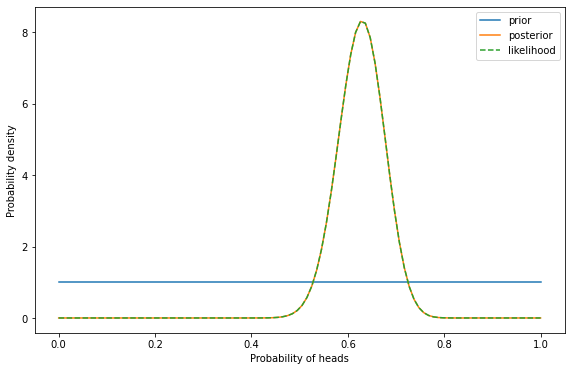

In [2]:
# Our lizard-flipping data
n = 100
h = 63
# Get equally spaced x values for plotting
x = np.linspace(0, 1, 100)
# We are assuming a uniform pror on pH, which is equivalent to a beta(a=1, b=1)
a = 1
b = 1
prior_density = beta.pdf(x = x, a = a, b = b)
# The posterior distribution and (scaled) likelihood function are both beta
# distributions (don't worry about why this is true)
likelihood_density = beta.pdf(x = x, a = h + 1, b = n - h + 1)
posterior_density = beta.pdf(x = x, a = a + h, b = b + n - h)
# Plot the prior, likelihood, and posterior
fig, ax = plt.subplots()
ax.plot(x, prior_density, label = "prior")
ax.plot(x, posterior_density, label = "posterior")
ax.plot(x, likelihood_density, label = "likelihood", linestyle = "--")
plt.xlabel("Probability of heads")
plt.ylabel("Probability density")
plt.legend()

*A quick aside: Don't worry too much about how the code above works.*
*In this simple example of lizard flipping, the posterior and (scaled) likelihood can be solved with a bit of math and turn out to be beta distributions.*
*I take advantage of that above so we can visualize the prior, likelihood, and posterior densities.*
*However, with most real-world models, we cannot solve for the posterior so easily, so don't worry about **why** the posterior is a beta distribution.*

So, Bayes' rule gives us a way to make probability statements about certain values of $p_H$, conditional on our data.
Let's try a different prior distribution to see how sensitive our posterior is to our *a priori* assumptions about the value of $p_H$.
Let's try a beta(1, 5) distribution (the uniform distribution we assumed above is equivalent to a beta(1, 1) distribution):

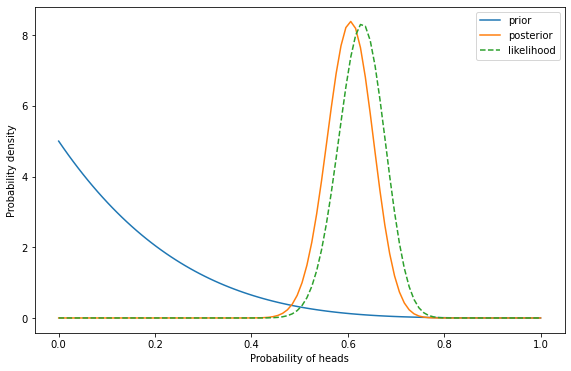

In [3]:
b = 5
prior_density = beta.pdf(x = x, a = a, b = b)
posterior_density = beta.pdf(x = x, a = a + h, b = b + n - h)
plt.plot(x, prior_density, label = "prior")
plt.plot(x, posterior_density, label = "posterior")
plt.plot(x, likelihood_density, label = "likelihood", linestyle = "--")
plt.xlabel("Probability of heads")
plt.ylabel("Probability density")
plt.legend()

As we can see, the posterior probability distribution for $p_H$ is quite robust to this large change in our prior assumption about $p_H$. It shifts a bit, but still prefers values in the neighborhood of 0.63.
This isn't too surprising.
Our beta(1, 5) distribution puts a lot of prior density toward $p_H = 0$.
Our 63 heads in 100 flips clearly demonstrates that is not true,
so our posterior is dominated by the data (likelihood).

Before we get into $M_1$, let's add some notation to our equations above, so that we know they apply to $M_2$:

\begin{equation}
    P(p_H | D, M_2) = \frac{P(D | p_H, M_2) P(p_H | M_2)}{P(D | M_2)}
\end{equation}

\begin{equation}
    P(D | M_2) = \int_{0}^{1} P(D | p_H, M_2) P(p_H | M_2) dp_H
\end{equation}

These equations are the same as the ones above, we have just made them more explicit to make it clear that they apply to $M_2$.

Now, let's turn our attention to Model 1.
Under $M_1$, the posterior probabiltiy density of $p_H$ given our data is

\begin{equation}
    P(p_H | D, M_1) = \frac{P(D | p_H, M_1) P(p_H | M_1)}{P(D | M_1)}
\end{equation}

Our prior assumption for $M_1$ is that $P(p_H | M_1) = 1$ when $p_H = 0.5$, and $0$ otherwise.
So, our posterior is only defined when $p_H = 0.5$, in which case the posterior is 1 ($P(p_H | D, M_1) = 1$).
Weird, right? The posterior is always one, no matter what the data are?
Yes, $M_1$ doesn't have any free parameters to allow it to learn from the data.

Because there are no free parameters to average over, the marginal probability of the data under $M_1$ is simply equal to the probability of the data when $p_H = 0.5$:

\begin{equation}
\begin{split}
    P(D | M_1) & = P(D | p_H, M_1) P(p_H | M_1) \\
    & = P(D | p_H = 0.5) P(p_H = 0.5) \\
    & = P(D | p_H = 0.5)
\end{split}
\end{equation}

In our case, we have $H = 63$ heads in $N = 100$ flips, and the likelihood is a binomial probability:

\begin{equation}
\begin{split}
    P(D | p_H = 0.5) & = P(H=63, N=100 | p_H = 0.5) \\
    & = \textrm{binomial}(k = 63, n = 100, p = 0.5)
\end{split}
\end{equation}

## Bayesian model comparison

Above, we used the conditional probability gymnastics of Bayes' rule to formulate the posterior probability distribution of $p_H$ under each model.
But, we want to know which model is "better."
Well, we can use Bayes' rule to get the posterior probability of each model:

\begin{equation}
    P(M_i | D) = \frac{P(D | M_i) P(M_i)}{P(D)}
\end{equation}

The probability of the data, is averaged over all possible models, weighted by their prior probability:

\begin{equation}
    P(D) = P(D | M_1)P(M_1) + P(D | M_2)P(M_2)
\end{equation}

This is very similar to what we did above (it is Bayes' rule, after all), but one difference is that we have replaced a likelihood density function (e.g., $P(D|p_H, M_2)$) with a marginal likelihood of a model (e.g., $P(D|M_2)$).
So, the mechanism by which our data change our prior beliefs is now a *marginal* (average) likelihood.
As we will see in a bit, that is an important difference.

If we assume *a priori* that the probability of the two models is equal, we get:

\begin{equation}
\begin{split}
    P(M_i | D) & = \frac{P(D | M_i) \frac{1}{2}}{P(D | M_1)\frac{1}{2} + P(D | M_2)\frac{1}{2}} \\
    & = \frac{P(D | M_i)}{P(D | M_1) + P(D | M_2)}
\end{split}
\end{equation}

So, to get the posterior probablity of each model, we need to calculate the marginal likelihood for our two models. We formulated these above, but didn't calculate them.

\begin{equation}
    P(D | M_2) = \int_{0}^{1} P(D | p_H, M_2) P(p_H | M_2) dp_H
\end{equation}

\begin{equation}
    P(D | M_1) = \textrm{binomial}(k = 63, n = 100, p = 0.5)
\end{equation}

Let's (again) assume a uniform prior distribution on $p_H$ and use a little Python code to calculate these marginal likelihoods, and then get the posterior probability of each model:

In [4]:
p_data_given_m1 = binom.pmf(k = 63, n = 100, p = 0.5)
m2 = BinomialModel(number_of_flips = 100,
                   number_of_heads = 63,
                   prior_beta_a = 1.0,
                   prior_beta_b = 1.0)
p_data_given_m2 = m2.get_marginal_likelihood()

p_data = p_data_given_m1 + p_data_given_m2

p_m1_given_data = p_data_given_m1 / p_data
p_m2_given_data = p_data_given_m2 / p_data

print("P(D | M_1) =", p_data_given_m1)
print("P(D | M_2) =", p_data_given_m2)
print("P(D) =", p_data)
print("P(M_1 | D) =", p_m1_given_data)
print("P(M_2 | D) =", p_m2_given_data)

P(D | M_1) = 0.002697927604718661
P(D | M_2) = 0.009900990099009696
P(D) = 0.012598917703728358
P(M_1 | D) = 0.2141396323209788
P(M_2 | D) = 0.7858603676790211


So, the posterior probability of Model 1 and 2 is about 0.214 and 0.786, respectively.
Did you expect larger differences in the posterior probabilities between the models, given the tiny P-values for $M_1$ and the large AIC weight for $M_2$ we saw in the book?
Why isn't there more support for Model 2?

Well, the frequentist approaches in the book are based on the maximum likelihoods of each model, whereas the Bayesian posterior probabilities are based on the *marginal* (or average) likelihoods of each model.
To get a sense of why that is an important difference, let's look at the plot of the prior, posterior, and likelihood under Model 2 again:

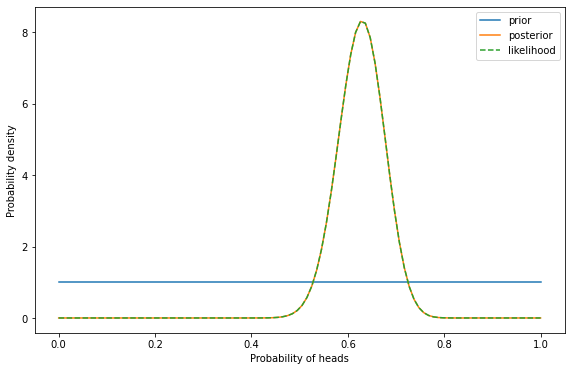

In [5]:
fig

When we marginalize the likelihood of Model 2, we are taking the average of the likelihood (the green dotted) line across the x-axis, and weighting that average by the prior (the blue line).
Looking at the plot above, we have quite a bit of prior weight on values of $p_H$ with very small likelihood.
That is going to "hurt" the average likelihood of Model 2.

Above, we saw that the posterior probability density of $p_H$ under Model 2 (i.e., Bayesian parameter estimation) seemed quite robust to different prior assumptions about $p_H$.
Will that still be true for Bayesian model choice, which is working with *marginal* likelihoods?
Let's test this and see!

Above we tried a beta(1, 5) prior on $p_H$ and saw only a small shift in the posterior of $p_H$ under $M_2$.
Let's see how a beta(1, 5) prior affects the posterior probabilities of the models:

In [6]:
# Changing the prior to beta(1,5) for Model 2
m2 = BinomialModel(number_of_flips = 100,
                   number_of_heads = 63,
                   prior_beta_a = 1.0,
                   prior_beta_b = 5.0)
p_data_given_m2 = m2.get_marginal_likelihood()

p_data = p_data_given_m1 + p_data_given_m2

p_m1_given_data = p_data_given_m1 / p_data
p_m2_given_data = p_data_given_m2 / p_data

print("P(D | M_1) =", p_data_given_m1)
print("P(D | M_2) =", p_data_given_m2)
print("P(D) =", p_data)
print("P(M_1 | D) =", p_m1_given_data)
print("P(M_2 | D) =", p_m2_given_data)

P(D | M_1) = 0.002697927604718661
P(D | M_2) = 0.0010487709454636315
P(D) = 0.0037466985501822926
P(M_1 | D) = 0.7200813112086094
P(M_2 | D) = 0.2799186887913906


With this change in prior assumption, the posterior probability of Model 1 and 2 are now 0.72 and 0.28, respectively.
Wow! The posterior probabilities have flipped, and now we prefer $M_1$! Whaaat?!

In general, Bayesian model choice tends to be much more sensitive to differences in the priors placed on the models' parameters than Bayesian parameter estimation.
This makes sense, because the posterior probability of a model is based on its marginal likelihood, which is averaged with respect to (and weighted by) the priors on the model's parameters ($p_H$ in our example).
This prior sensitivity may seem alarming, but can actually be viewed as a positive feature of Bayesian model choice; the priors serve as a "natural" penalty for adding parameters to a model.
But, we have to be careful not to choose priors that put lots of weight in regions of parameter space that are biologically unreasonable, because this can "sink" a good model!

Just to reiterate, Bayesian model choice can be sensitive to the priors chosen for the *parameters* of the models.
When doing model comparison, it's easy to worry about the prior probabilities we use for the models themselves (we assumed they are both equally probable above), and forget about the priors on the models' parameters.
But, as we just demonstrated, the priors on the parameters can be *very* important!

### Bayes factors

Bayes factors are another common way of comparing models in Bayesian statistics.
A Bayes factor is the factor by which the posterior odds of a model has changed from its prior odds.
This is easy to see if we take the ratio of the posterior probabilities of two models; the denominator ($P(D)$) cancels, and we are left with:

\begin{equation}
\frac{P(M_1 | D)}{P(M_2 | D)} = \frac{P(D | M_1)}{P(D | M_2)} \times \frac{P(M_1)}{P(M_2)}
\end{equation}

The posterior odds is simply the prior odds multiplied by the ratio of the models' marginal likelihoods, which is the Bayes factor.
With a little rearranging, we can see that the ratio of the posterior odds to the prior odds is also equal to the Bayes factor

\begin{equation}
\textrm{Bayes factor} = \frac{P(D | M_1)}{P(D | M_2)} = \frac{\frac{P(M_1 | D)}{P(M_2 | D)}}{\frac{P(M_1)}{P(M_2)}}
\end{equation}

This gives us two ways of calculating a Bayes factor to compare 2 models: By getting their marginal likelihoods and taking the ratio, *or* getting the posterior probabilities and taking their ratio and dividing by the ratio of the prior probabilities.
They are equivalent (barring approximation error), but depending on the models, one whay might be much easier than the other.